# Comparison of MEFISTO and PRISMO on Visium Data from MEFISTO paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import scanpy as sc
import matplotlib.pyplot as plt
import umap
import pandas as pd
import seaborn as sns
import numpy as np

from data_loader import load_mefisto_visium

import mofaflex as mfl

/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
adata = load_mefisto_visium()
adata.var_names = adata.var_names.str.upper()
adata

/home/aqoku/projects/code_new/mofaflex-analysis/comparison_mefisto_visium/data_loader.py:9: FutureWarning: Use `squidpy.read.visium` instead.
/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/home/aqoku/projects/code_new/mofaflex-analysis/comparison_mefisto_visium/data_loader.py:31: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.


AnnData object with n_obs × n_vars = 2487 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

<Axes: >

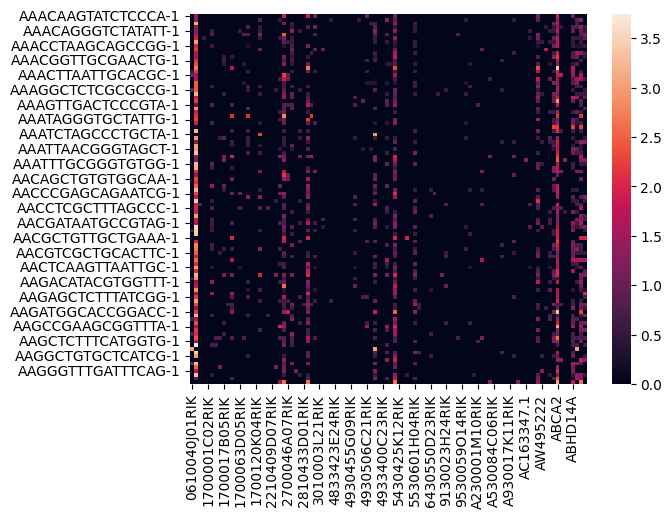

In [4]:
sns.heatmap(adata.to_df().iloc[:100, :100])

In [5]:
feature_stds = adata.to_df().std()
(feature_stds > 0).mean()

np.float64(1.0)

In [6]:
def to_upper(feature_set_collection):
    return mfl.FeatureSets(
        [
            mfl.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

In [7]:
hallmark_collection = mfl.FeatureSets.from_gmt(
    "../msigdb/mh.all.v2024.1.Mm.symbols.gmt", name="hallmark"
)


panglao_df = pd.read_csv("../msigdb/PanglaoDB_markers_27_Mar_2020.tsv", sep="\t")
panglao_df = panglao_df.loc[panglao_df["species"].isin(["Mm Hs", "Mm"]) & (panglao_df["organ"] == "Brain"), :].copy()

celltype_collection = mfl.FeatureSets.from_dataframe(panglao_df.groupby("cell type").agg(list).reset_index(), name="celltype", name_col="cell type", features_col="official gene symbol", desc_col="product description")

# celltype_collection = feature_sets.from_gmt(
#     "../../msigdb/c8.all.v7.5.1.symbols.gmt", name="celltype"
# )

# merge both collections
gene_set_collection = celltype_collection
gene_set_collection = to_upper(gene_set_collection)
gene_set_collection
# sorted([fs.name for fs in gene_set_collection])

<FeatureSets 'celltype' with 34 feature sets>

In [8]:
gene_set_collection = gene_set_collection.filter(
    adata.var_names, min_fraction=0.1, min_count=5, max_count=300, 
)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection

<FeatureSets 'celltype' with 24 feature sets>

In [9]:
adata.varm["gene_set_mask"] = gene_set_collection.to_mask(
    adata.var_names.tolist()
).T

In [10]:
device = "cpu"
try:
    device = f"cuda:{mfl.tl.get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:0'

In [11]:
data_opts = mfl.DataOptions(
    group_by=None, 
    scale_per_group=True, 
    covariates_obs_key=None, 
    covariates_obsm_key={"group_1" : "spatial"}, 
    annotations_varm_key={"view_1": "gene_set_mask"}, 
    use_obs="union", 
    use_var="union", 
    plot_data_overview=False
)

In [12]:
model_opts = mfl.ModelOptions(
    n_factors=1, 
    weight_prior={"view_1": "Horseshoe"}, 
    factor_prior={"group_1" : "GP"}, 
    likelihoods="Normal", 
    nonnegative_weights=True, 
    nonnegative_factors=True, 
    prior_penalty=0.003, 
    init_factors="random", 
    init_scale=0.1
)

In [ ]:
training_opts = mfl.TrainingOptions(
    device=device,  
    max_epochs=10000, 
    n_particles=1, 
    lr=0.003, 
    early_stopper_patience=100, 
    save_path=None, 
    seed=None
)

In [14]:
smooth_opts = mfl.SmoothOptions(
    n_inducing=100, 
    kernel="RBF", 
    warp_groups=[], 
    warp_interval=20, 
    warp_open_begin=True, 
    warp_open_end=True, 
    warp_reference_group=None
)

In [15]:
model = mfl.MOFAFLEX({"group_1": {"view_1": adata}}, model_opts, data_opts, training_opts, smooth_opts)

WARNING	Could not import dask. Data arrays may be copied, resulting in high memory usage.
INFO	Initializing factors using `random` method...
  0%|          | 0/10000 [00:00<?, ?epochs/s]/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:654.)
 81%|████████  | 8066/10000 [37:44<09:02,  3.56epochs/s, Loss=904]
INFO	Saving results to mofafle

In [16]:
factor_adata = model.get_factors("anndata")
factor_adata

{np.str_('group_1'): AnnData object with n_obs × n_vars = 2487 × 25
     obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'}

In [17]:
z_df = factor_adata["group_1"].to_df()
z_df.head()

,Factor 1,Astrocytes,Bergmann glia,Cajal-Retzius cells,Choroid plexus cells,Dopaminergic neurons,Ependymal cells,GABAergic neurons,Immature neurons,Interneurons,...,Neurons,Oligodendrocyte progenitor cells,Oligodendrocytes,Purkinje neurons,Pyramidal cells,Retinal ganglion cells,Satellite glial cells,Schwann cells,Tanycytes,Trigeminal neurons
AAACAAGTATCTCCCA-1,1.372604,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,1.424988,0.000000,0.0,0.0,0.0,0.697009,0.0,0.0
AAACACCAATAACTGC-1,1.348962,1.309217,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.058910,...,0.000000,0.0,0.000000,0.681629,0.0,0.0,0.0,0.000000,0.0,0.0
AAACAGAGCGACTCCT-1,1.122539,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1.356954,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
AAACAGCTTTCAGAAG-1,1.384974,0.122999,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.835042,...,0.000000,0.0,0.000000,2.148055,0.0,0.0,0.0,0.000000,0.0,0.0
AAACAGGGTCTATATT-1,1.412844,0.104962,0.0,0.0,0.0,0.0,0.0,0.0,0.272779,0.571998,...,0.000000,0.0,0.000000,2.071894,0.0,0.0,0.0,0.000000,0.0,0.0


In [18]:
cov_df = pd.DataFrame(model.covariates["group_1"], index=model.sample_names["group_1"])
cov_df[1] = -cov_df[1]
cov_df.head()

,0,1
AAACAAGTATCTCCCA-1,0.281447,-0.093462
AAACACCAATAACTGC-1,-0.433983,-0.231952
AAACAGAGCGACTCCT-1,0.212560,0.460366
AAACAGCTTTCAGAAG-1,-0.520156,0.014194
AAACAGGGTCTATATT-1,-0.485712,-0.047342


In [29]:
relevant_factors = [
    'Neurons',
    'Interneurons',
    'Oligodendrocytes',
    'Purkinje neurons',
    'Choroid plexus cells',
    'Meningeal cells',
]

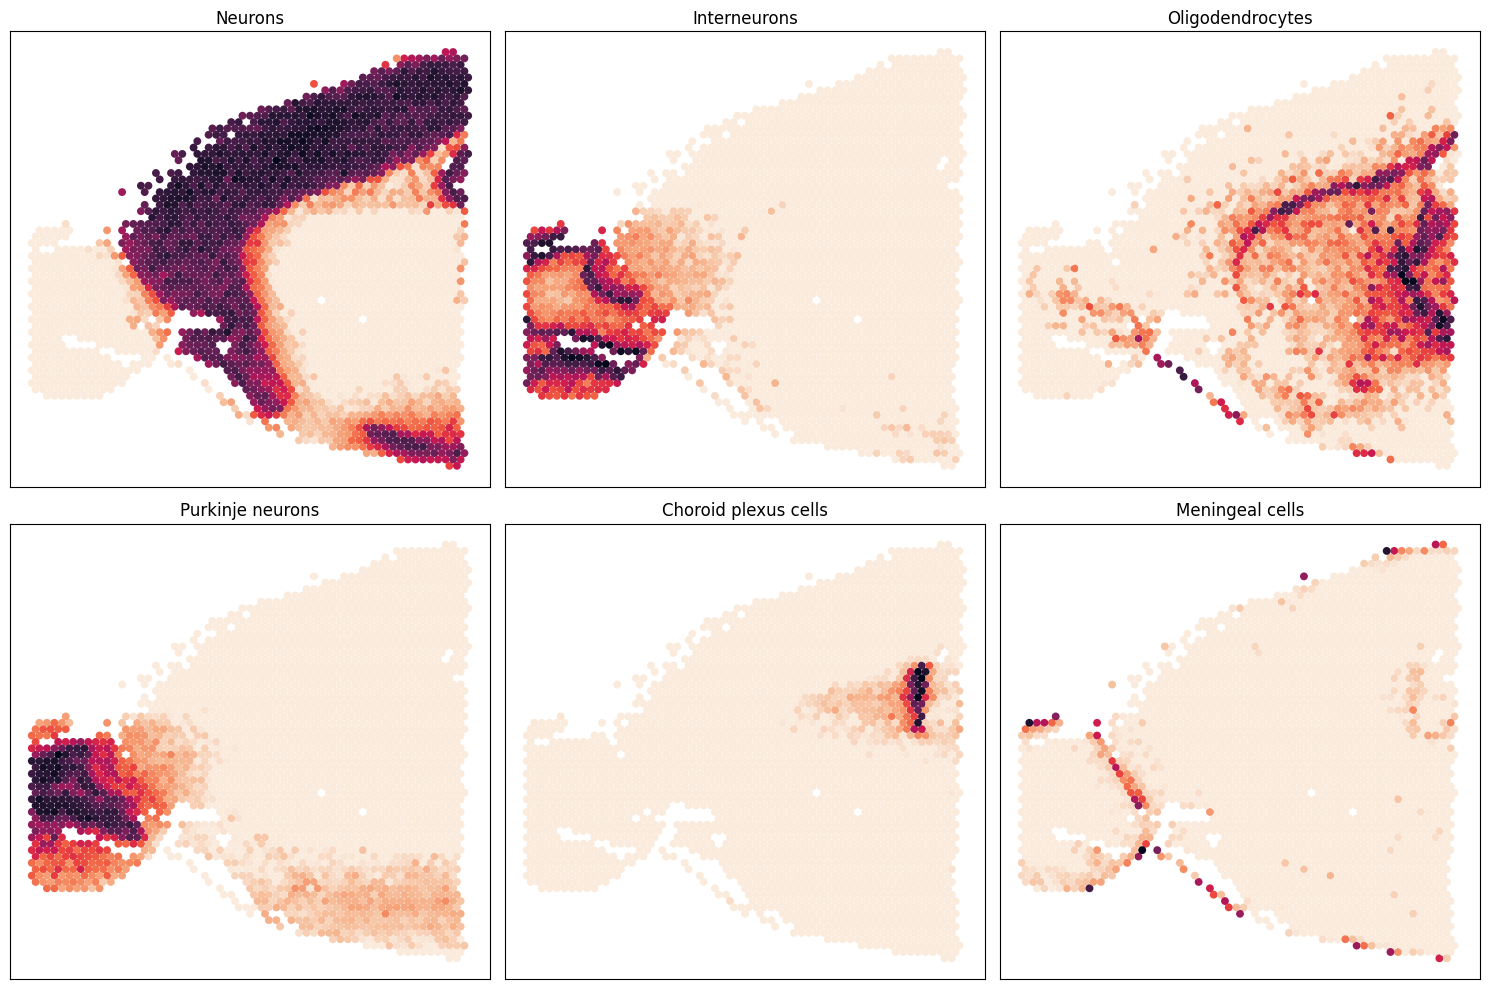

In [30]:
ncols = 3
nrows = ((len(relevant_factors) + ncols - 1) // ncols)
fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols * 5, nrows * 5), squeeze=False)
for i, rf in enumerate(relevant_factors):
    ax = sns.scatterplot(
        pd.concat([z_df, cov_df], axis=1), 
        # pd.concat([model.data["group_1"]["view_1"].to_df(), cov_df], axis=1), 
        x=0, 
        y=1, 
        hue=rf, 
        s=32, 
        palette=sns.color_palette("rocket_r", as_cmap=True),
        ax=axs[i // ncols, i % ncols],
        linewidth=0.0, 
        alpha = 1.0,
        rasterized=True,
        legend=False
    )
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_title(rf)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    # ax.set_xticks(ticks=[], labels=[])
    # ax.set_yticks(ticks=[], labels=[])

plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
fig.tight_layout()
plt.show()

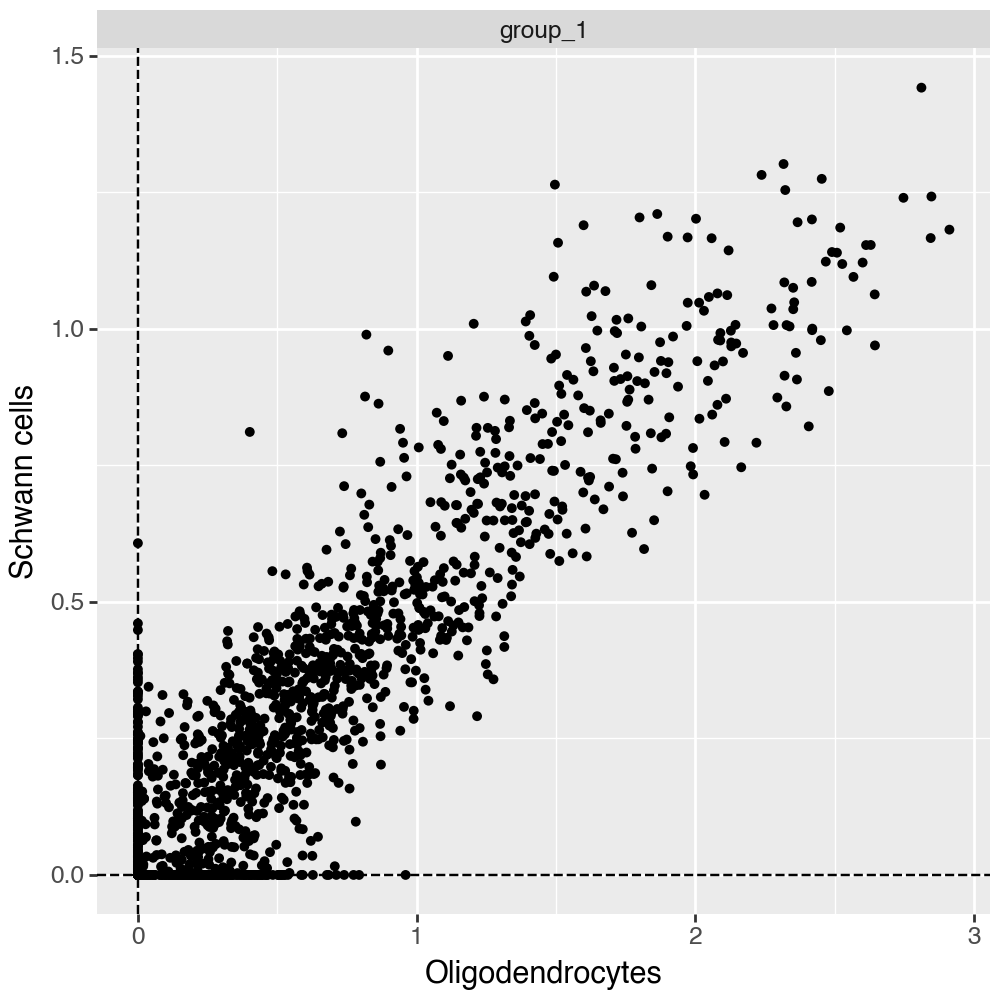

In [31]:
mfl.pl.factors_scatter(model, "Oligodendrocytes", "Schwann cells")

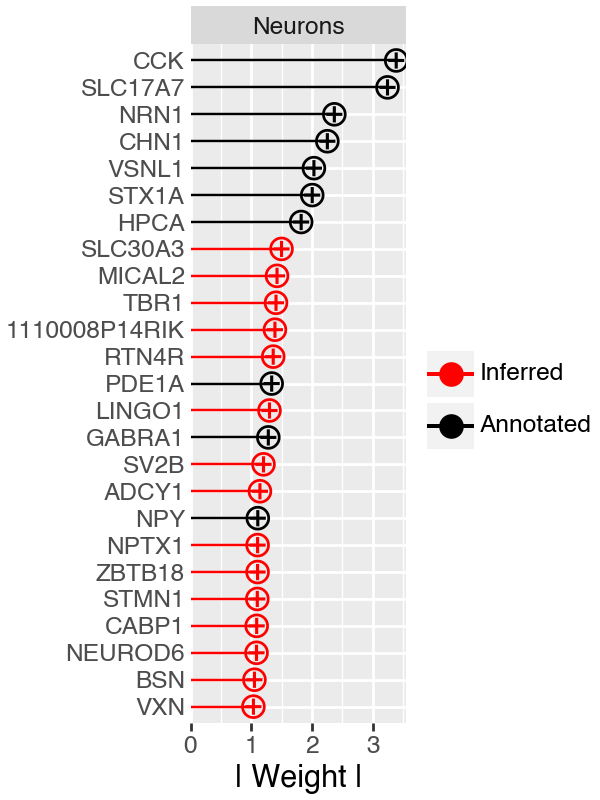

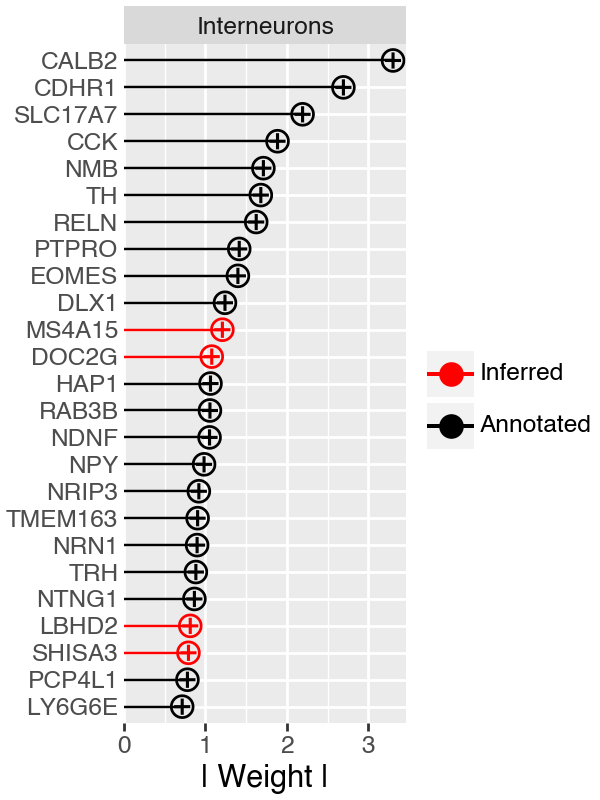

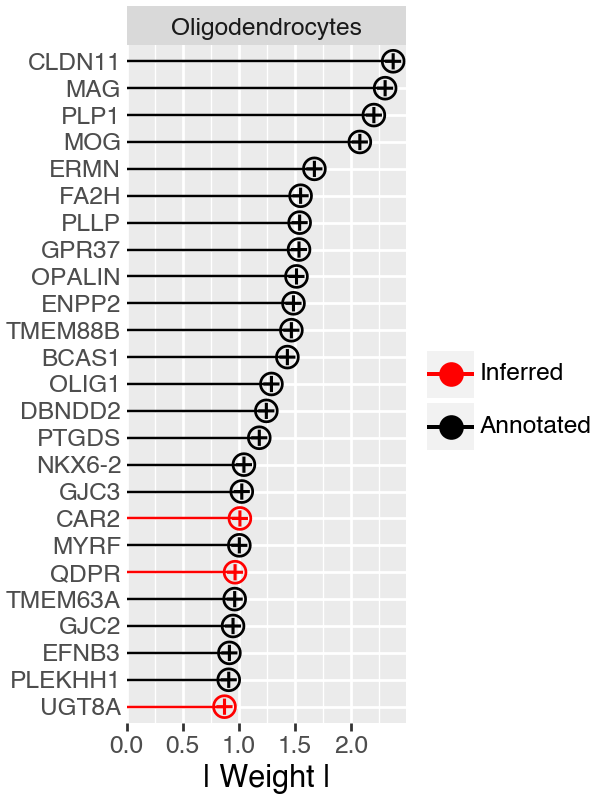

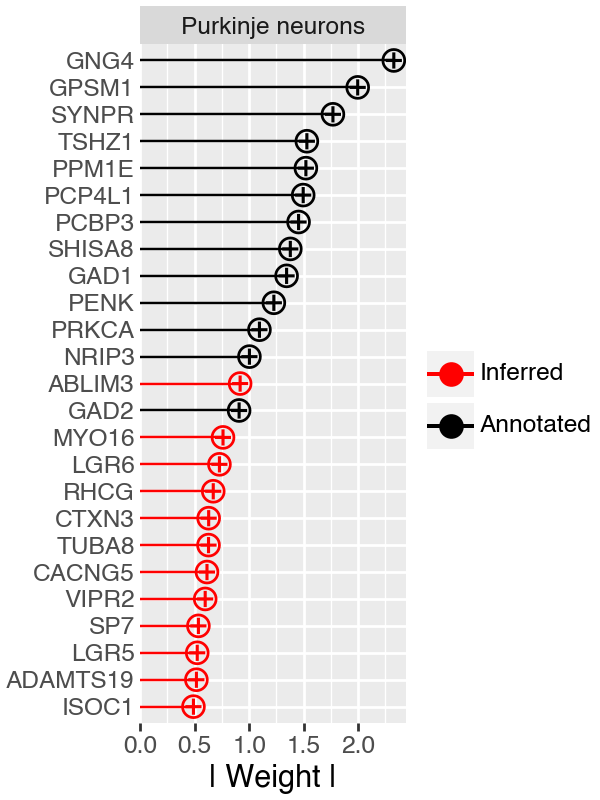

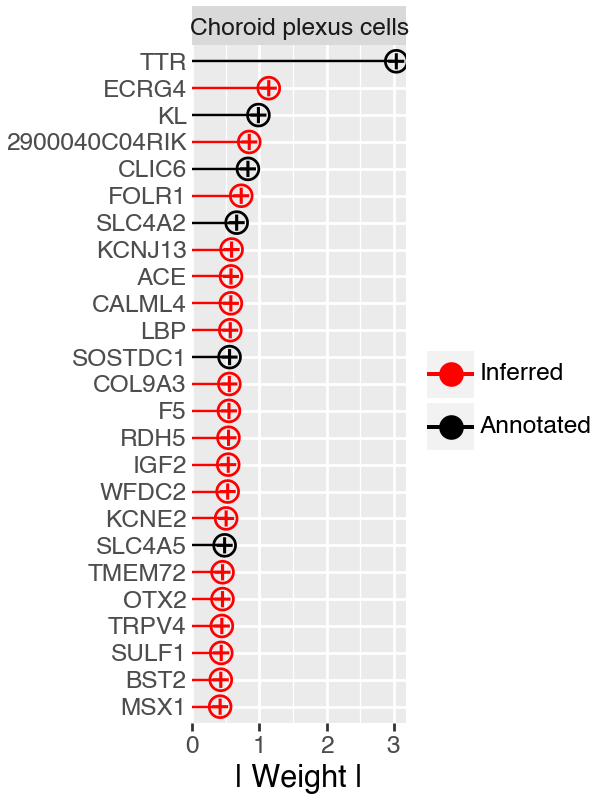

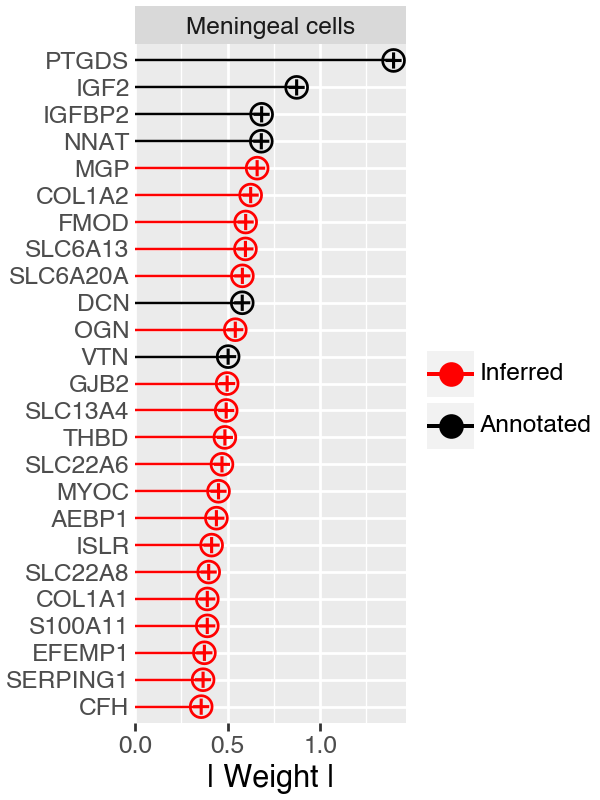

In [32]:
for rf in relevant_factors:
    p = mfl.pl.top_weights(model, 25, factors=rf, figsize=(3, 4))
    p.show()